#Prediction using U-Net for Face Mask


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the Dataset file
- This file contains images with details of bounding boxes

In [2]:
import numpy as np
data = np.load('/content/drive/MyDrive/dataset/Advanced Computer Vision/Dataset- Images.npy', allow_pickle=True)

In [8]:
data[25][1]

[{'imageHeight': 350,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.49, 'y': 0.20285714285714285},
   {'x': 0.58, 'y': 0.41714285714285715}]}]

### Set image dimensions 

In [10]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Features and Labels

In [11]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Spliting the data into training and testing 


In [12]:
X_train = X[:400] #400 images in training 400 images in training and 9 images in testing data
y_train = masks[:400]

In [13]:
X_test = X[400:]
y_test = masks[400:]

Image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IMAGE_ARRAY [[[-0.08235294 -0.25490195 -0.44313723]
  [-0.15294117 -0.32549018 -0.51372552]
  [-0.34117645 -0.51372552 -0.7019608 ]
  ...
  [ 0.41176474  0.3176471   0.19215691]
  [ 0.41176474  0.3176471   0.19215691]
  [ 0.41176474  0.3176471   0.19215691]]

 [[-0.20784312 -0.38039213 -0.56862748]
  [-0.21568626 -0.38823527 -0.57647061]
  [-0.02745098 -0.19215685 -0.38039213]
  ...
  [ 0.45098042  0.36470592  0.22352946]
  [ 0.45098042  0.36470592  0.22352946]
  [ 0.45098042  0.36470592  0.22352946]]

 [[-0.12941176 -0.31764704 -0.50588238]
  [-0.17647058 -0.36470586 -0.5529412 ]
  [-0.05098039 -0.24705881 -0.43529409]
  ...
  [ 0.48235297  0.38039219  0.24705887]
  [ 0.49019611  0.38823533  0.25490201]
  [ 0.49019611  0.38823533  0.25490201]]

 ...

 [[-0.372549   -0.57647061 -0.81176472]
  [-0.39607841 -0.60000002 -0.83529413]
  [-0.44313723 -0.64705884 -0.88235295]
  ...
  [-0.18431371 -0.39607841 -0.63137257]
  [-0.19215685 -0.40392154 -0.63921571]
  [-0.28627449 -0.48235291 -0.72

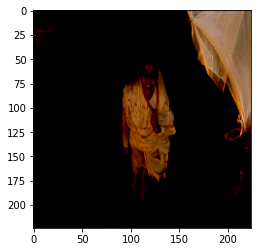

In [16]:
import matplotlib.pyplot as plt

n = 25    
print("IMAGE_ARRAY", X_train[n])
plt.imshow(X_train[n])

Print the mask

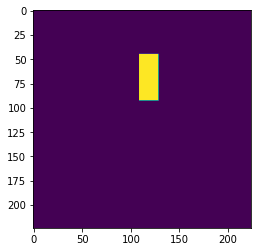

In [17]:
plt.imshow(masks[n])

## Create the model 

In [18]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

### Create_Model function 

In [19]:
model = create_model()

17235968/17225924 [==============================] - 0s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)


### Model Summary 

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Coefficient Function


In [22]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

def dice_coefficient(y_true, y_pred):
    numerator = 2 * reduce_sum(y_true * y_pred)
    denominator = reduce_sum(y_true + y_pred)
    return numerator / (denominator + epsilon())

###Loss Function 

In [23]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [24]:
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

### Setting callbacks

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model

In [26]:
model.fit(X_train, y_train, epochs=10, batch_size=1, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
400/400 [==============================] - 75s 104ms/step - loss: 1.2118 - dice_coefficient: 0.5164

Epoch 00001: loss improved from inf to 1.21180, saving model to model-1.21.h5
Epoch 2/10
400/400 [==============================] - 42s 105ms/step - loss: 0.8581 - dice_coefficient: 0.5997

Epoch 00002: loss improved from 1.21180 to 0.85813, saving model to model-0.86.h5
Epoch 3/10
400/400 [==============================] - 42s 105ms/step - loss: 0.7053 - dice_coefficient: 0.6527

Epoch 00003: loss improved from 0.85813 to 0.70528, saving model to model-0.71.h5
Epoch 4/10
400/400 [==============================] - 42s 105ms/step - loss: 0.6345 - dice_coefficient: 0.6823

Epoch 00004: loss improved from 0.70528 to 0.63448, saving model to model-0.63.h5
Epoch 5/10
400/400 [==============================] - 42s 105ms/step - loss: 0.6671 - dice_coefficient: 0.6732

Epoch 00005: loss did not improve from 0.63448
Epoch 6/10
400/400 [==============================] - 42s 105ms/step 

### Get the predicted mask for a test image 

Test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


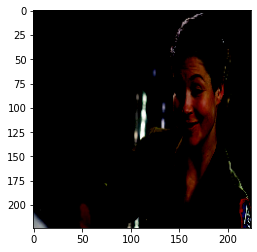

In [28]:
m = 5
plt.imshow(X_test[m])

Original mask for test image

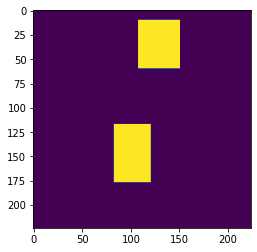

In [29]:
plt.imshow(masks[m])

Predict the mask on the test image

In [30]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[m]]))[0] > 0.5), (IMAGE_WIDTH, IMAGE_HEIGHT)) 

### Implement the mask on the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


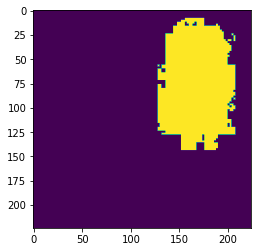

In [33]:
plt.imshow(X_test[m])
plt.imshow(pred_mask, alpha=1)